In [61]:
# import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn import metrics
from sklearn.metrics import mean_squared_error
import mlflow
import mlflow.sklearn

import nltk
from nltk.tokenize import word_tokenize

import re

import matplotlib.pyplot as plt
%matplotlib inline

import math

import warnings
warnings.filterwarnings('ignore')

In [62]:
df = pd.read_csv('new_combined_results.csv')
df.head(2)

,id,title,company,description,source,location,min_salary,max_salary
0,1,Senior Software Engineer - Remote,Akamai,**Are you a software developer who loves solvi...,indeed.com,United States,"$113,430","$170,043"
1,2,Software Engineer II,Microsoft,Microsoft’s Azure Data engineering team is lea...,indeed.com,United States,"$94,300","$182,600"


In [63]:
import re
from decimal import Decimal

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
# print(df[['min_salary', 'max_salary']])
      
# Function to convert salary strings to Decimal and add the corresponding label
def convert_salary(salary_str):
    if isinstance(salary_str, str):
        # Use regular expressions to extract the numeric part of the string
        match = re.search(r'\d+(\.\d+)?', salary_str)
        if match:
            numeric_part = match.group()
            numeric_value = Decimal(numeric_part.replace(',', ''))  # Convert to Decimal
            if 'K' in salary_str:
                return int(numeric_value), 'per year'
            elif ',' in salary_str:
                return int(numeric_value), 'per year'
            elif '.' in salary_str:
                return int(numeric_value), 'per hour'
            else:
                return int(numeric_value), 'per hour'
    else:
        # If it's already a number (no conversion needed)
        return salary_str, ''


# Apply the function to 'min_salary' and 'max_salary' columns
df['min_salary_year'], df['salary_type'] = zip(*df['min_salary'].apply(convert_salary))
df['max_salary_year'], _ = zip(*df['max_salary'].apply(convert_salary))

# Calculate annual salary based on 40 hours/week and 52 weeks/year for rows with 'on_hours'
df.loc[df['salary_type'] == 'per hour', ['min_salary_year', 'max_salary_year']] *= 40 * 52
df.loc[df['salary_type'] == 'per hour', ['min_salary_year', 'max_salary_year']] /= 1000

df = df.fillna(value=0)
df = df.astype({"min_salary_year":'int', "max_salary_year":'int'})
df.to_csv('your_file.csv', index=False) 
print(df[:1])



   id                              title company  \
0   1  Senior Software Engineer - Remote  Akamai   

                                         description      source  \
0  **Are you a software developer who loves solvi...  indeed.com   

        location min_salary max_salary  min_salary_year salary_type  \
0  United States   $113,430   $170,043              113    per year   

   max_salary_year  
0              170  


In [64]:
print("Data Shape:", df.shape)

Data Shape: (937, 11)


In [65]:
# randomly sample 900 rows from the data
import random
random.seed(1)
indices = df.index.values.tolist()

random_900 = random.sample(indices, 900)

random_900[:5]

[137, 582, 867, 821, 782]

In [66]:
# subset the imported data on the selected 2500 indices
train = df.loc[random_900, :]
train = train.reset_index(drop = True)
train.head()

,id,title,company,description,source,location,min_salary,max_salary,min_salary_year,salary_type,max_salary_year
0,138,Data Engineer Technical Specialist,Peraton,**Peraton Overview** \nPeraton drives mission...,indeed.com,United States,"$146,000","$234,000",146,per year,234
1,583,Software Engineer - Fullstack,Brigit3.8 ★,"Hi, we're Brigit! A holistic financial health ...",glassdoor.com,"New York, NY",$100K,$170K,100,per year,170
2,868,Data Scientist,LifeScale Analytics,"At Lifescale Analytics, we help achieve data-d...",glassdoor.com,"Eagan, MN",$87K,$119K,87,per year,119
3,822,Data Scientist (Exempt),Mercy3.5 ★,We're a Little Different\n\nOur mission is cle...,glassdoor.com,"Chesterfield, MO",$86K,$122K,86,per year,122
4,783,Data Scientist,Praxis Precision Medicines2.6 ★,Data Scientist\nLocation: This position may be...,glassdoor.com,"Charlestown, MA",$80K,$90K,80,per year,90


In [67]:
train.columns.values

array(['id', 'title', 'company', 'description', 'source', 'location',
       'min_salary', 'max_salary', 'min_salary_year', 'salary_type',
       'max_salary_year'], dtype=object)

In [68]:
def convert_utf8(s):
    return str(s)

train['description'] = train['description'].map(convert_utf8)

In [69]:
# Remove the urls first - Anything that has .com, .co.uk or www. is a url!
def remove_urls(s):
    s = re.sub('[^\s]*.com[^\s]*', "", s)
    s = re.sub('[^\s]*www.[^\s]*', "", s)
    s = re.sub('[^\s]*.co.uk[^\s]*', "", s)
    return s

train['Clean_Full_Descriptions'] = train['description'].map(remove_urls)

In [70]:
# Remove the star_words
def remove_star_words(s):
    return re.sub('[^\s]*[\*]+[^\s]*', "", s)

train['Clean_Full_Descriptions'] = train['Clean_Full_Descriptions'].map(remove_star_words)

In [71]:
def remove_nums(s):
    return re.sub('[^\s]*[0-9]+[^\s]*', "", s)

train['Clean_Full_Descriptions'] = train['Clean_Full_Descriptions'].map(remove_nums)

In [72]:
# Remove the punctuations
from string import punctuation

def remove_punctuation(s):
    global punctuation
    for p in punctuation:
        s = s.replace(p, '')
    return s

train['Clean_Full_Descriptions'] = train['Clean_Full_Descriptions'].map(remove_punctuation)

In [73]:
# Convert to lower case
train['Clean_Full_Descriptions'] = train['Clean_Full_Descriptions'].map(lambda x: x.lower())


In [74]:
import nltk

In [75]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/yuliiaantonova/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [76]:
print(nltk.pos_tag(word_tokenize("I love riding my motorcycle")))

[('I', 'PRP'), ('love', 'VBP'), ('riding', 'VBG'), ('my', 'PRP$'), ('motorcycle', 'NN')]


In [77]:
# make a corpus of all the words in the job description
corpus = " ".join(train['Clean_Full_Descriptions'].tolist())

# This is the NLTK function that breaks a string down to its tokens
tokens = word_tokenize(corpus)

# Get the parts of speech tag for all words
answer = nltk.pos_tag(tokens)
answer_pos = [a[1] for a in answer]

# print a value count for the parts of speech
all_pos = pd.Series(answer_pos)
all_pos.value_counts().head()

NN     135729
NNS     65070
JJ      58116
IN      54132
CC      34646
Name: count, dtype: int64

In [78]:
import nltk

In [79]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yuliiaantonova/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [80]:
# store english stopwords in a list
from nltk.corpus import stopwords
en_stopwords = stopwords.words('english')

# define a function to remove stopwords from descriptions
def remove_stopwords(s):
    global en_stopwords
    s = word_tokenize(s)
    s = " ".join([w for w in s if w not in en_stopwords])
    return s

# Create a new column of descriptions with no stopwords
train['Clean_Full_Descriptions_no_stop'] = train['Clean_Full_Descriptions'].map(remove_stopwords)

# make a corpus of all the words in the job description
corpus = " ".join(train['Clean_Full_Descriptions_no_stop'].tolist())

# This is the NLTK function that breaks a string down to its tokens
tokens = word_tokenize(corpus)

answer = nltk.pos_tag(tokens)
answer_pos = [a[1] for a in answer]

all_pos = pd.Series(answer_pos)
all_pos.value_counts().head()

NN     129343
NNS     63953
JJ      58874
VBP     21985
VBG     19690
Name: count, dtype: int64

In [81]:
# prepare corpus from the descriptions that still have stopwords
corpus = " ".join(train['Clean_Full_Descriptions'].tolist())

#tokenize words
tokenized_corpus = nltk.word_tokenize(corpus)
fd = nltk.FreqDist(tokenized_corpus)

# get the top words
top_words = []
for key, value in fd.items():
    top_words.append((key, value))

# sort the list by the top frequencies
top_words = sorted(top_words, key = lambda x:x[1], reverse = True)

# keep top 100 words only
top_words = top_words[:100]

# Keep the frequencies only from the top word series
top_word_series = pd.Series([w for (v,w) in top_words])
top_word_series[:5]

# get actual ranks of these words - wherever we see same frequencies, we give same rank
word_ranks = top_word_series.rank(method = 'min', ascending = False)

The value of theta obtained is: [-1.04001396]


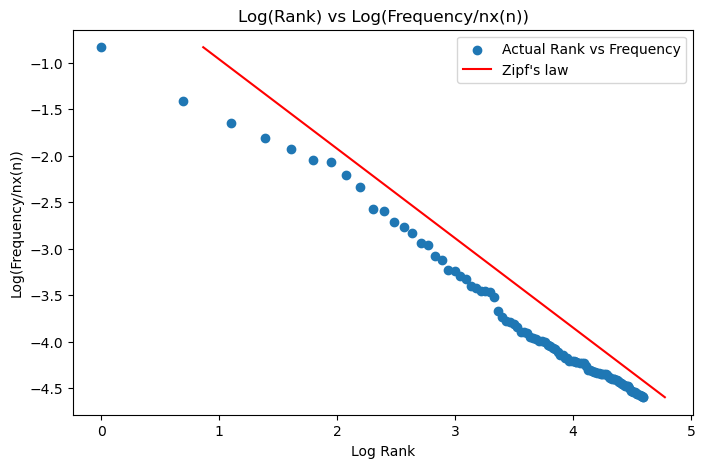

In [82]:
# Get the value of the denominator n*x_n
denominator = max(word_ranks)*min(top_word_series)

# Y variable is the log of word ranks and X is the word frequency divided by the denominator
# above
Y = np.array(np.log(word_ranks))
X = np.array(np.log(top_word_series/denominator))

# fit a linear regression to these, we dont need the intercept!
from sklearn import linear_model
reg_model = linear_model.LinearRegression(fit_intercept = False)
reg_model.fit(Y.reshape(-1,1), X)
print("The value of theta obtained is:",reg_model.coef_)

# make a plot of actual rank obtained vs theoretical rank expected
plt.figure(figsize = (8,5))
plt.scatter(Y, X, label = "Actual Rank vs Frequency")
plt.title('Log(Rank) vs Log(Frequency/nx(n))')
plt.xlabel('Log Rank')
plt.ylabel('Log(Frequency/nx(n))')

plt.plot(reg_model.predict(X.reshape(-1,1)), X, color = 'red', label = "Zipf's law")
plt.legend()

In [83]:
# import the necessary functions from the nltk library
from nltk.stem.wordnet import WordNetLemmatizer
lmtzr = WordNetLemmatizer()

In [84]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/yuliiaantonova/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [85]:
# prepare corpus from the descriptions that dont have stopwords
corpus = " ".join(train['Clean_Full_Descriptions_no_stop'].tolist())

#tokenize words
tokenized_corpus = nltk.word_tokenize(corpus)

# lemmatize these tokens
lemmatized_tokens = [lmtzr.lemmatize(token) for token in tokenized_corpus]

# word frequencies for the lemmatized tokens
fd = nltk.FreqDist(lemmatized_tokens)

# get the top words
top_words = []
for key, value in fd.items():
    top_words.append((key, value))

# sort the list by the top frequencies
top_words = sorted(top_words, key = lambda x:x[1], reverse = True)

# keep top 10 words only
top_words = top_words[:10]

top_words

[('data', 9744),
 ('experience', 5328),
 ('work', 3111),
 ('team', 3056),
 ('year', 2239),
 ('business', 2208),
 ('’', 2106),
 ('skill', 1663),
 ('development', 1447),
 ('solution', 1412)]

In [86]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/yuliiaantonova/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [87]:
# import the necessary functions from the nltk library
from nltk.stem.wordnet import WordNetLemmatizer
lmtzr = WordNetLemmatizer()

# prepare corpus from the descriptions that dont have stopwords
corpus = " ".join(train['Clean_Full_Descriptions_no_stop'].tolist())

#tokenize words
tokenized_corpus = nltk.word_tokenize(corpus)

# lemmatize these tokens
lemmatized_tokens = [lmtzr.lemmatize(token) for token in tokenized_corpus]

# word frequencies for the lemmatized tokens
fd = nltk.FreqDist(lemmatized_tokens)

# get the top words
top_words = []
for key, value in fd.items():
    top_words.append((key, value))

# sort the list by the top frequencies
top_words = sorted(top_words, key = lambda x:x[1], reverse = True)

# keep top 10 words only
top_words = top_words[:10]

top_words

[('data', 9744),
 ('experience', 5328),
 ('work', 3111),
 ('team', 3056),
 ('year', 2239),
 ('business', 2208),
 ('’', 2106),
 ('skill', 1663),
 ('development', 1447),
 ('solution', 1412)]

In [88]:
# get the 75th percentile value of salary!
sal_perc_75 = np.percentile(train['max_salary_year'], 75)

# make a new target variable that captures whether salary is high (1) or low (0)
train['Salary_Target'] = np.where(train['max_salary_year'] >= sal_perc_75, 1, 0)

In [89]:
train.head()

,id,title,company,description,source,location,min_salary,max_salary,min_salary_year,salary_type,max_salary_year,Clean_Full_Descriptions,Clean_Full_Descriptions_no_stop,Salary_Target
0,138,Data Engineer Technical Specialist,Peraton,**Peraton Overview** \nPeraton drives mission...,indeed.com,United States,"$146,000","$234,000",146,per year,234,\nperaton drives missions of consequence sp...,peraton drives missions consequence spanning g...,1
1,583,Software Engineer - Fullstack,Brigit3.8 ★,"Hi, we're Brigit! A holistic financial health ...",glassdoor.com,"New York, NY",$100K,$170K,100,per year,170,hi were brigit a holistic financial helping e...,hi brigit holistic financial helping every ame...,1
2,868,Data Scientist,LifeScale Analytics,"At Lifescale Analytics, we help achieve data-d...",glassdoor.com,"Eagan, MN",$87K,$119K,87,per year,119,at lifescale analytics we help achieve datadri...,lifescale analytics help achieve datadriven de...,0
3,822,Data Scientist (Exempt),Mercy3.5 ★,We're a Little Different\n\nOur mission is cle...,glassdoor.com,"Chesterfield, MO",$86K,$122K,86,per year,122,were a little different\n\nour mission is clea...,little different mission clear bring life heal...,0
4,783,Data Scientist,Praxis Precision Medicines2.6 ★,Data Scientist\nLocation: This position may be...,glassdoor.com,"Charlestown, MA",$80K,$90K,80,per year,90,data scientist\nlocation this position may be ...,data scientist location position may performed...,0


In [90]:
train.dtypes.value_counts()

object    10
int64      4
Name: count, dtype: int64

In [91]:
train.isnull().sum()[train.isnull().sum()>0]

Series([], dtype: int64)

In [92]:
# this gives us the categorical variables and the number of unique entries in them!
train.select_dtypes('object').nunique(dropna = False)

title                              430
company                            730
description                        889
source                               2
location                           159
min_salary                         377
max_salary                         382
salary_type                          3
Clean_Full_Descriptions            889
Clean_Full_Descriptions_no_stop    882
dtype: int64

In [93]:
train['Salary_Target'].value_counts()/len(train)


Salary_Target
0    0.746667
1    0.253333
Name: count, dtype: float64

In [94]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")

mlflow.set_experiment("yuli")


<Experiment: artifact_location='/Users/yuliiaantonova/Downloads/pythonProject8/mlruns/1', creation_time=1705702197747, experiment_id='1', last_update_time=1705702197747, lifecycle_stage='active', name='yuli', tags={}>

In [95]:
def log_confusion_matrix(conf_matrix):
    # Helper function to save confusion matrix as a text file
    output_path = "confusion_matrix.txt"
    np.savetxt(output_path, conf_matrix, fmt="%d")
    return output_path

def log_mlflow(model, X_test, y_test, model_name, developer_name, data_path):
    with mlflow.start_run():

        mlflow.set_tag("developer", developer_name)

        mlflow.log_param("model_name", model_name)
        mlflow.log_param("train-data-path", data_path)

        # Fit the model and predict the output on the test data
        # model.fit(X_train, y_train)
        # predicted = model.predict(X_test)

        # Log metrics
        accuracy = metrics.accuracy_score(y_test, predicted)
        roc_auc = metrics.roc_auc_score(y_test, predicted)
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("roc_auc", roc_auc)

        # Calculate and log RMSE
        rmse = mean_squared_error(y_test, predicted, squared=False)
        mlflow.log_metric("rmse", rmse)

        # Log confusion matrix as artifact
        confusion_matrix = metrics.confusion_matrix(y_test, predicted)
        mlflow.log_artifact(log_confusion_matrix(confusion_matrix))

        # Log the model as an artifact
        mlflow.sklearn.log_model(model, "model")
        mlflow.end_run()

        print("Model Accuracy is:", accuracy)
        print("Area under the ROC curve:", roc_auc)
        print("Confusion Matrix:\n", confusion_matrix)

In [96]:
# Replace 'train' and 'y_val' with your actual data
columns_required = ['title', 'company', 'source', 'location', 'Salary_Target']
train_b1 = train[columns_required]

# Convert the categorical variables to dummy variables
train_b1 = pd.get_dummies(train_b1)

# Separate predictors from the target variable
columns_selected = train_b1.columns.values.tolist()
target_variable = ['Salary_Target']

# Predictors are all variables except for the target variable
predictors = list(set(columns_selected) - set(target_variable))

# Setup the model
X = np.array(train_b1[predictors])
y = np.array(train_b1[target_variable[0]])

# Create test train splits 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

model = BernoulliNB()

model.fit(X_train, y_train)
predicted = model.predict(X_test)

# Use the log_mlflow function
log_mlflow(model, X_test, y_test, "BernoulliNB", "yulia", "./new_combined_results.csv")


Model Accuracy is: 0.8222222222222222
Area under the ROC curve: 0.5789473684210527
Confusion Matrix:
 [[142   0]
 [ 32   6]]


In [97]:
### Create a Pickle file using serialization 
import pickle
pickle_out = open("classifier.pkl","wb")
pickle.dump(model, pickle_out)
pickle_out.close()

In [98]:
import numpy as np

In [99]:
import pickle
import numpy as np

# Load the trained model from the Pickle file
with open("classifier.pkl", "rb") as file:
    model = pickle.load(file)

# Create a function to make predictions
def predict_salary(title, company, source, location):
    # Ensure the input features match the expected number of features (1321)
    num_features = 1321
    input_data = [0] * num_features  # Initialize with zeros

    # Assign values to the available features (title, company, source, location)
    input_data[0] = title
    input_data[1] = company
    input_data[2] = source
    input_data[3] = location

    # Make a prediction using the loaded model
    prediction = model.predict([input_data])

    # Return the prediction
    if prediction[0] == 1:
        return "Fake note"
    else:
        return "It's a Job note"

# Example usage
result = predict_salary(2, 3, 4, 1)
print(result)


It's a Job note


In [100]:
mlflow.end_run()

In [101]:
# Lets lemmatize the job descriptions before we run the model
def text_lemmatizer(s):
    '''Given a description, this lemmatizes it'''
    tokenized_corpus = nltk.word_tokenize(s)
    
    # lemmatize
    s = " ".join([lmtzr.lemmatize(token) for token in tokenized_corpus])
    return s

# lemmatize the descriptions
train['Clean_Full_Descriptions_no_stop_lemm'] = train['Clean_Full_Descriptions_no_stop'].map(text_lemmatizer)
value_at_index_0 = train['Clean_Full_Descriptions_no_stop_lemm'][0]
print("Value at index 0:", type(value_at_index_0))
# print(train['Clean_Full_Descriptions_no_stop_lemm'])
# make the X and y matrices for model fitting
X = np.array(train.loc[:, 'Clean_Full_Descriptions_no_stop_lemm'])

y = np.array(train.loc[:, 'Salary_Target'])

# split into test and train data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2)

# Convert the arrays into a presence/absence matrix
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer()
X_train_counts = count_vectorizer.fit_transform(X_train)
X_test_counts = count_vectorizer.transform(X_test)

from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()


model.fit(X_train_counts, y_train)
predicted = model.predict(X_test_counts)

log_mlflow(model, X_test_counts, y_test, "MultinomialNB", "yulia", "./new_combined_results.csv")

Value at index 0: <class 'str'>
Model Accuracy is: 0.8166666666666667
Area under the ROC curve: 0.7392512972572275
Confusion Matrix:
 [[124  18]
 [ 15  23]]


In [102]:
# Calculate the frequencies of words using the TfidfTransformer
X_train_bern = np.where(X_train_counts.todense() > 0 , 1, 0)
X_test_bern = np.where(X_test_counts.todense() > 0, 1, 0)

# Fit the model
from sklearn.naive_bayes import BernoulliNB
nb_bern_model = BernoulliNB().fit(X_train_bern, y_train)


In [103]:
import numpy as np
predicted = nb_bern_model.predict(X_test_bern)

# print the accuracies
print("Model Accuracy:", metrics.accuracy_score(y_test, predicted))
print("Area under the ROC curve:", metrics.roc_auc_score(y_test, predicted))
print("Model Confusion Matrix:\n", metrics.confusion_matrix(y_test, predicted))

Model Accuracy: 0.8
Area under the ROC curve: 0.6515937731653076
Model Confusion Matrix:
 [[129  13]
 [ 23  15]]


In [104]:
# extract the column names for the columns in our training dataset.
column_names = [x for (x,y) in sorted(count_vectorizer.vocabulary_.items(), key = lambda x:x[1])]

# probability of high salary
p_1 = np.mean(y_train)

# probability of low salary
p_0 = 1 - p_1

# create an array of feature vectors
feature_vectors = np.array(X_train_bern)

# probability of word appearance
word_probabilities = np.mean(feature_vectors, axis = 0)

# probability of seeing these words for class= 1 and class = 0 respectively
p_x_1 = np.mean(feature_vectors[y_train==1, :], axis = 0)
p_x_0 = np.mean(feature_vectors[y_train==0, :], axis = 0)

# words that are good indicators of high salary (class = 1)
high_indicators = p_x_1 * (np.log2(p_x_1) - np.log2(word_probabilities) - np.log2(p_1))

high_indicators_series = pd.Series(high_indicators, index = column_names)

# words that are good indicators of low salary (class = 0)
low_indicators = p_x_0 * (np.log2(p_x_0) - np.log2(word_probabilities) - np.log2(p_0))

low_indicators_series = pd.Series(low_indicators, index = column_names)


In [105]:
low_indicators_series[[i for i in low_indicators_series.index if i not in en_stopwords]].sort_values(ascending = False)[:100].index

Index(['work', 'experience', 'data', 'skill', 'year', 'team', 'ability',
       'requirement', 'solution', 'development', 'business', 'technology',
       'sql', 'degree', 'job', 'required', 'knowledge', 'strong', 'develop',
       'support', 'bachelor', 'tool', 'system', 'database', 'analysis',
       'design', 'information', 'related', 'management', 'including',
       'process', 'analytics', 'position', 'working', 'opportunity', 'benefit',
       'using', 'provide', 'engineer', 'environment', 'science', 'project',
       'python', 'service', 'type', 'source', 'preferred', 'new',
       'application', 'education', 'responsibility', 'analyst', 'location',
       'software', 'employee', 'role', 'field', 'time', 'professional',
       'engineering', 'need', 'remote', 'hour', 'quality', 'schedule',
       'qualification', 'understand', 'technical', 'understanding', 'must',
       'health', 'analytical', 'performance', 'maintain', 'one', 'industry',
       'employer', 'report', 'andor', '

In [106]:
high_indicators_series[[i for i in high_indicators_series.index if i not in en_stopwords]].sort_values(ascending = False)[:100].index

Index(['experience', 'work', 'team', 'opportunity', 'year', 'role', 'data',
       'engineering', 'product', 'disability', 'range', 'science', 'business',
       'benefit', 'salary', 'including', 'may', 'location', 'build', 'working',
       'new', 'skill', 'building', 'equal', 'platform', 'people', 'learning',
       'status', 'help', 'environment', 'need', 'process', 'base', 'design',
       'time', 'degree', 'protected', 'also', 'python', 'across', 'make',
       'employee', 'age', 'race', 'pay', 'law', 'like', 'best', 'job',
       'development', 'gender', 'national', 'technical', 'factor', 'veteran',
       'candidate', 'medical', 'employer', 'applicable', 'color', 'system',
       'scientist', 'religion', 'position', 'origin', 'well', 'problem',
       'language', 'engineer', 'solution', 'world', 'support', 'sexual',
       'applicant', 'orientation', 'application', 'identity', 'impact',
       'field', 'based', 'employment', 'value', 'please', 'user', 'use',
       'technology',